In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import words as english_words
import string
import re
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
nltk.download('punkt')
nltk.download('words')

In [117]:
df = pd.read_csv("/Users/kenneth/Desktop/ML-project/training_set_rel3.tsv", delimiter='\t', encoding='latin1')
test_data = pd.read_csv("/Users/kenneth/Desktop/ML-project/test_set.tsv", delimiter='\t', encoding='latin1')
validation_data = pd.read_csv("/Users/kenneth/Desktop/ML-project/valid_set.tsv", delimiter='\t', encoding='latin1')
v1 = pd.read_csv('/Users/kenneth/Desktop/ML-project/valid_sample_submission_2_column.csv', header=1,names=['prediction_id', 'predicted_score'])
validation_data = pd.merge(v1, validation_data, left_on='prediction_id', right_on='domain1_predictionid')
df = df.drop(columns=['rater1_domain1','rater2_domain1','rater3_domain1','rater1_domain2','rater2_domain2','rater1_trait1','rater1_trait2','rater1_trait3','rater1_trait4','rater1_trait5','rater1_trait6','rater2_trait1','rater2_trait2','rater2_trait3','rater2_trait4','rater2_trait5','rater2_trait6','rater3_trait1','rater3_trait2','rater3_trait3','rater3_trait4','rater3_trait5','rater3_trait6'])

In [ ]:
X = df['essay']
y = df['domain1_score']
vectorizer = TfidfVectorizer(max_features=10)

X_train= vectorizer.fit_transform(X)
X_test = vectorizer.transform(validation_data['essay'])
y_train = y
y_test = validation_data['predicted_score']

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Machine": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "RandomForestRegressor": RandomForestRegressor()
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    score = model.score(X_train, y_train)
    print('----------------------')
    print("Metrics:")
    print(f"MSE: {mse}")
    print(f"RMSE: {np.sqrt(mse)}")
    print(f"R²: {r2}")
    print(f"SCORE: {score}%")
    print('----------------------\n')


## Évaluation des performances des modèles avec TfidfVectorizer

L'objectif de cette première approche était d'évaluer la performance de différents modèles de régression lorsqu'ils sont utilisés en conjonction avec la fonction TfidfVectorizer pour représenter nos données textuelles.

Les résultats montrent que les performances des modèles varient considérablement :

- Les modèles linéaires, tels que la régression linéaire et la régression Ridge, ont des performances similaires mais limitées, avec un coefficient de détermination (R²) d'environ 0.28, indiquant qu'ils ne parviennent pas à expliquer une grande partie de la variance des données.

- La régression Lasso et l'arbre de décision présentent des performances encore plus faibles, avec des valeurs de R² proches de zéro ou négatives, suggérant une mauvaise adéquation aux données ou un surajustement massif, respectivement.

- Les modèles de machine à vecteurs de support (SVM) et de k plus proches voisins (KNN) montrent une légère amélioration par rapport aux modèles linéaires, mais leur capacité à expliquer la variance des données reste limitée, avec un R² d'environ 0.35.

- En revanche, le modèle de forêt aléatoire se démarque avec le MSE le plus bas (~41.6) et le R² le plus élevé (~0.46). De plus, il présente un score élevé sur les données d'entraînement sans montrer de signes de surajustement excessif, suggérant qu'il pourrait être une option prometteuse pour la modélisation de ces données.

Ces résultats suggèrent que la représentation vectorielle des données textuelles avec TfidfVectorizer peut jouer un rôle crucial dans la performance des modèles de régression. Cela souligne l'importance d'explorer différentes approches de représentation des données textuelles et de sélectionner soigneusement les modèles appropriés en fonction des besoins spécifiques du problème.


In [ ]:
moyenne_par_categorie = df.groupby('essay_set').size().mean()
taille_exacte_8 = len(df[df['essay_set'] == 8])
reste = int(moyenne_par_categorie - taille_exacte_8)
duplique1 = df[df['essay_set'] == 8].sample(n=reste, replace=True)
df2 = pd.concat([df, duplique1])
df2 = df2.sample(frac=1, random_state=42)
print(df2['essay_set'].value_counts())

## Sur-échantillonnage pour équilibrer les classes

Afin de traiter le déséquilibre de la distribution des classes dans notre ensemble de données, nous avons mis en œuvre une technique de sur-échantillonnage pour équilibrer les différentes catégories d'essais.

1. **Calcul de la moyenne du nombre d'instances par catégorie d'essais :** Nous avons calculé la moyenne du nombre d'instances par catégorie d'essais dans notre ensemble de données.

2. **Identification de la taille de la catégorie sous-représentée :** Ensuite, nous avons identifié la taille exacte de la catégorie ayant le moins d'instances.

3. **Sur-échantillonnage de la catégorie sous-représentée :** Pour compenser cette différence et atteindre la moyenne par catégorie, nous avons dupliqué aléatoirement des instances de la catégorie sous-représentée jusqu'à ce qu'elle atteigne la taille moyenne des autres catégories. Par exemple, pour la catégorie d'essais 8, qui avait initialement moins d'instances que la moyenne par catégorie, nous avons dupliqué aléatoirement des instances jusqu'à ce qu'elle atteigne la taille moyenne des autres catégories. Cette duplication a été effectuée de manière aléatoire et avec remplacement pour éviter tout biais dans les données.

4. **Mélange de l'ensemble de données :** Enfin, nous avons mélangé l'ensemble de données pour garantir une répartition aléatoire des instances et éviter tout effet de séquence dans l'apprentissage des modèles.


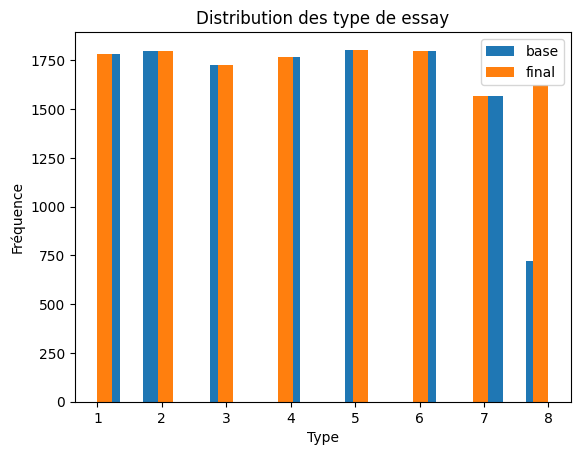

In [74]:
plt.hist(df['essay_set'], bins=20, alpha=1, label='base')
plt.hist(df2['essay_set'], bins=30, alpha=1, label='final')
plt.title('Distribution des type de essay')
plt.xlabel('Type')
plt.ylabel('Fréquence')
plt.legend()
plt.show()


## Distribution des types d'essais avant et après le sur-échantillonnage

La figure ci-dessous illustre la distribution des différents types d'essais avant et après l'application du sur-échantillonnage pour équilibrer les classes.

La distribution des types d'essais avant le sur-échantillonnage est représentée par la première série, tandis que la seconde série représente la distribution après l'application du sur-échantillonnage. On observe clairement que le processus de sur-échantillonnage a permis d'équilibrer la distribution des types d'essais, rendant ainsi les classes plus uniformes et équitables.


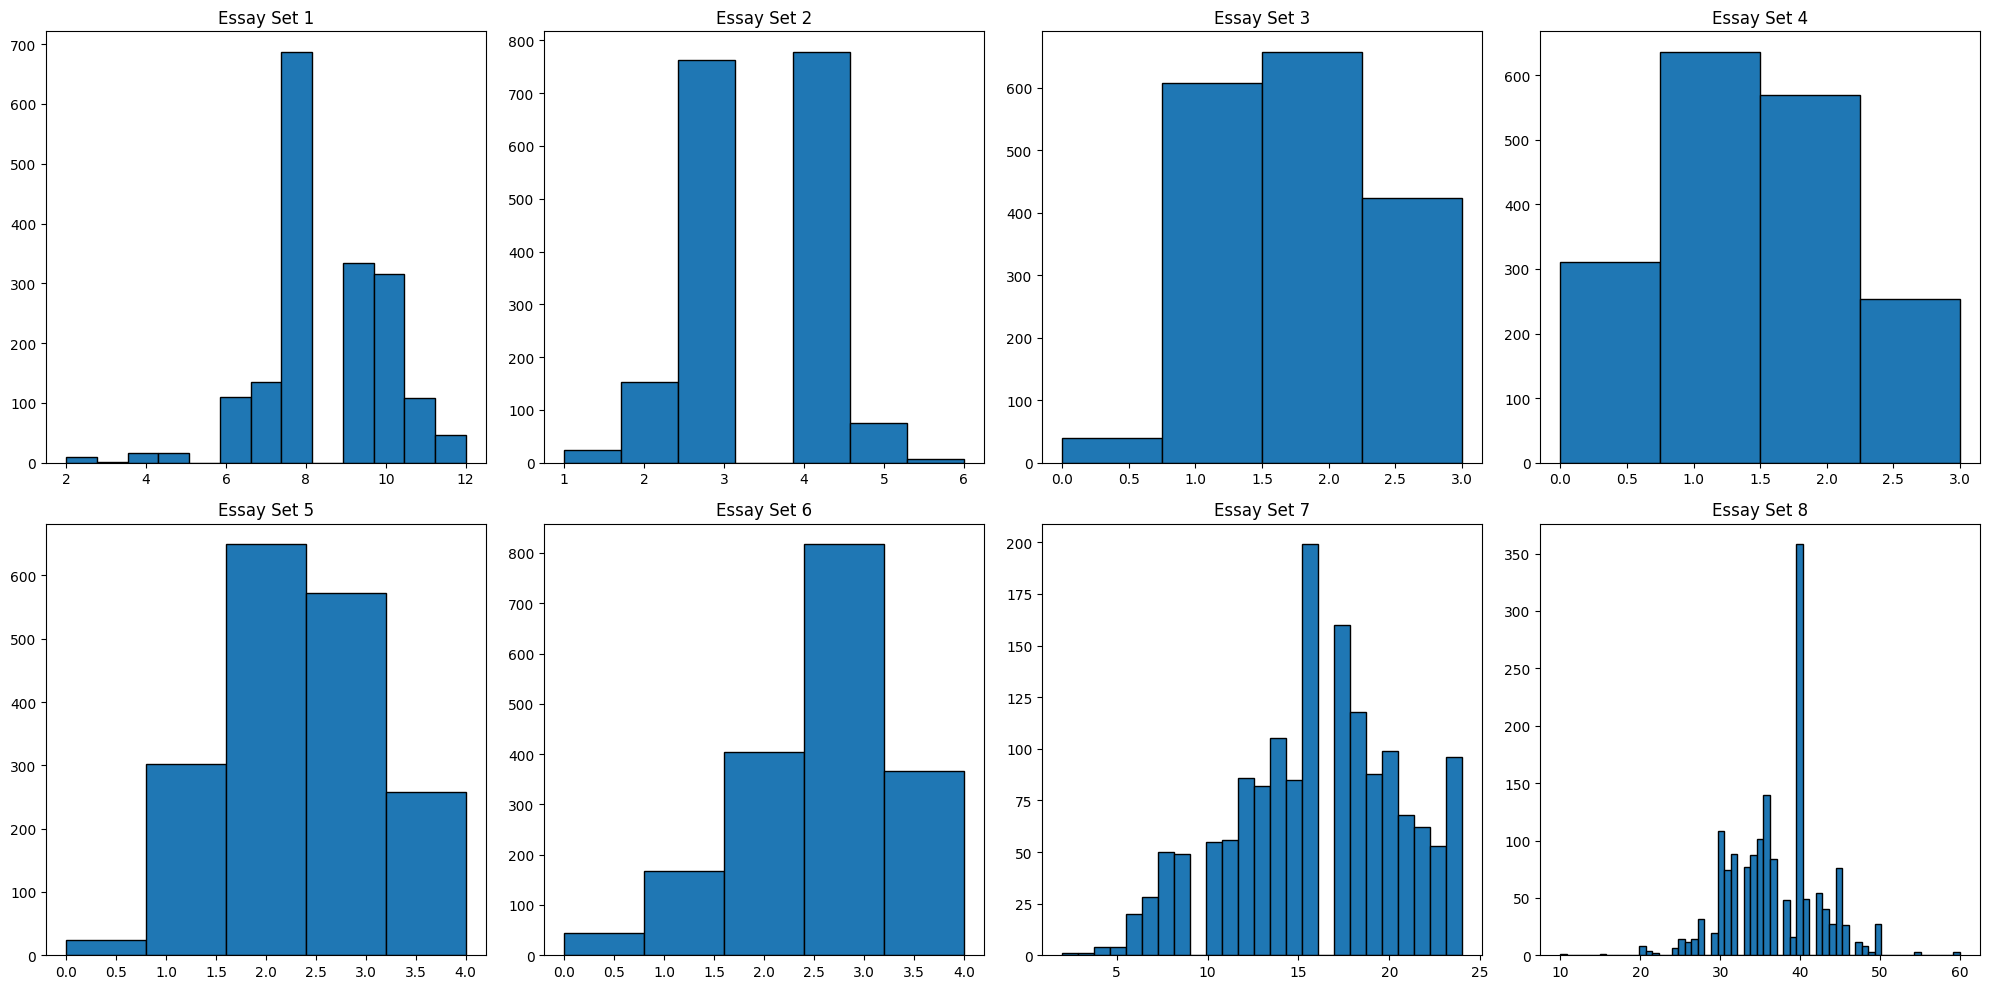

In [75]:
max_scores = df2.groupby('essay_set')['domain1_score'].max()
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, essay_set_value in enumerate(range(1, 9)):
    ax = axs[i // 4, i % 4]
    ax.hist(df2['domain1_score'][df2['essay_set'] == essay_set_value], bins=(max_scores[essay_set_value])+1, edgecolor='black')
    ax.set_title(f"Essay Set {essay_set_value}")
plt.tight_layout()
plt.show()

## Variabilité des performances par catégorie d'essais

La distribution des scores par catégorie d'essais, illustrée dans le graphique ci-dessus, est une représentation visuelle de la variabilité des performances des étudiants dans chaque type d'essai, après avoir équilibré les classes à l'aide du sur-échantillonnage.

Chaque sous-graphique représente une catégorie d'essais différente, allant de 1 à 8. Sur l'axe horizontal, nous avons les différents scores attribués, tandis que l'axe vertical représente la fréquence de chaque score.

Nous observons que la distribution des scores varie d'une catégorie d'essais à une autre. Certaines catégories peuvent présenter une distribution relativement uniforme des scores, tandis que d'autres peuvent avoir des scores plus concentrés autour de certaines valeurs.

Cette variabilité dans la distribution des scores peut fournir des insights précieux sur la complexité et la difficulté relatives de chaque type d'essai. Par exemple, une catégorie avec une distribution de scores plus étalée pourrait indiquer une plus grande variété dans les compétences évaluées, tandis qu'une distribution plus concentrée pourrait suggérer une évaluation plus spécifique et ciblée.

Comprendre cette distribution des scores par catégorie d'essais peut nous aider à mieux interpréter les performances des modèles d'évaluation automatique et à identifier les défis potentiels dans l'évaluation des essais. Cela nous permet également d'adapter nos stratégies d'enseignement et d'évaluation pour mieux répondre aux besoins des étudiants dans chaque type d'essai.


In [76]:
def overSamplerSousCategorie(data, colonneDuType):
    over_sampler = RandomOverSampler(random_state=42)
    df_resampled = pd.DataFrame()
    for essay_set_value in data[colonneDuType].unique():
        data_subset = data[data[colonneDuType] == essay_set_value]
        X = data_subset.drop('domain1_score', axis=1)
        y = data_subset['domain1_score']
        X_resampled, y_resampled = over_sampler.fit_resample(X, y)
        df_resampled_subset = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='domain1_score')], axis=1)
        df_resampled = pd.concat([df_resampled, df_resampled_subset], ignore_index=True)
    return df_resampled
df3 = overSamplerSousCategorie(df2, 'essay_set')

## Importance de l'équilibrage des classes dans l'analyse et la modélisation

Ce code effectue une opération de suréchantillonnage aléatoire des données pour chaque sous-catégorie d'essais (définie par la colonne 'essay_set') dans un DataFrame.

L'équilibrage des différentes notes des divers types d'essais revêt une importance cruciale dans le processus d'analyse et de modélisation. Ce processus garantit une représentation juste et équilibrée de toutes les classes de notes, ce qui contribue à améliorer significativement la performance et la fiabilité des modèles d'apprentissage automatique.

Tout d'abord, un équilibrage adéquat permet de minimiser les biais potentiels dans l'apprentissage automatique. En s'assurant que toutes les classes de notes sont traitées de manière égale, les modèles sont moins susceptibles de privilégier les classes majoritaires au détriment des classes minoritaires, ce qui se traduit par des prédictions plus précises et fiables.

De plus, l'équilibrage des classes favorise une meilleure généralisation du modèle. En accordant une attention égale à toutes les classes de notes, le modèle apprend à reconnaître et à prédire correctement les caractéristiques de chaque type d'essai, ce qui améliore ses performances globales et sa capacité à fournir des évaluations pertinentes.

Sur le plan éthique, l'équilibrage des classes favorise l'équité et l'impartialité dans la prise de décision automatisée. En garantissant que toutes les classes sont représentées de manière égale, nous nous assurons que les décisions prises par le modèle sont impartiales et équitables, ce qui contribue à éviter les préjugés indésirables et à promouvoir une prise de décision plus juste.

En conclusion, équilibrer les différentes notes des différents types d'essais est essentiel pour garantir des performances fiables et équitables des modèles d'apprentissage automatique. Cela contribue à renforcer la confiance dans les résultats du modèle et à garantir une prise de décision éthique et équitable.


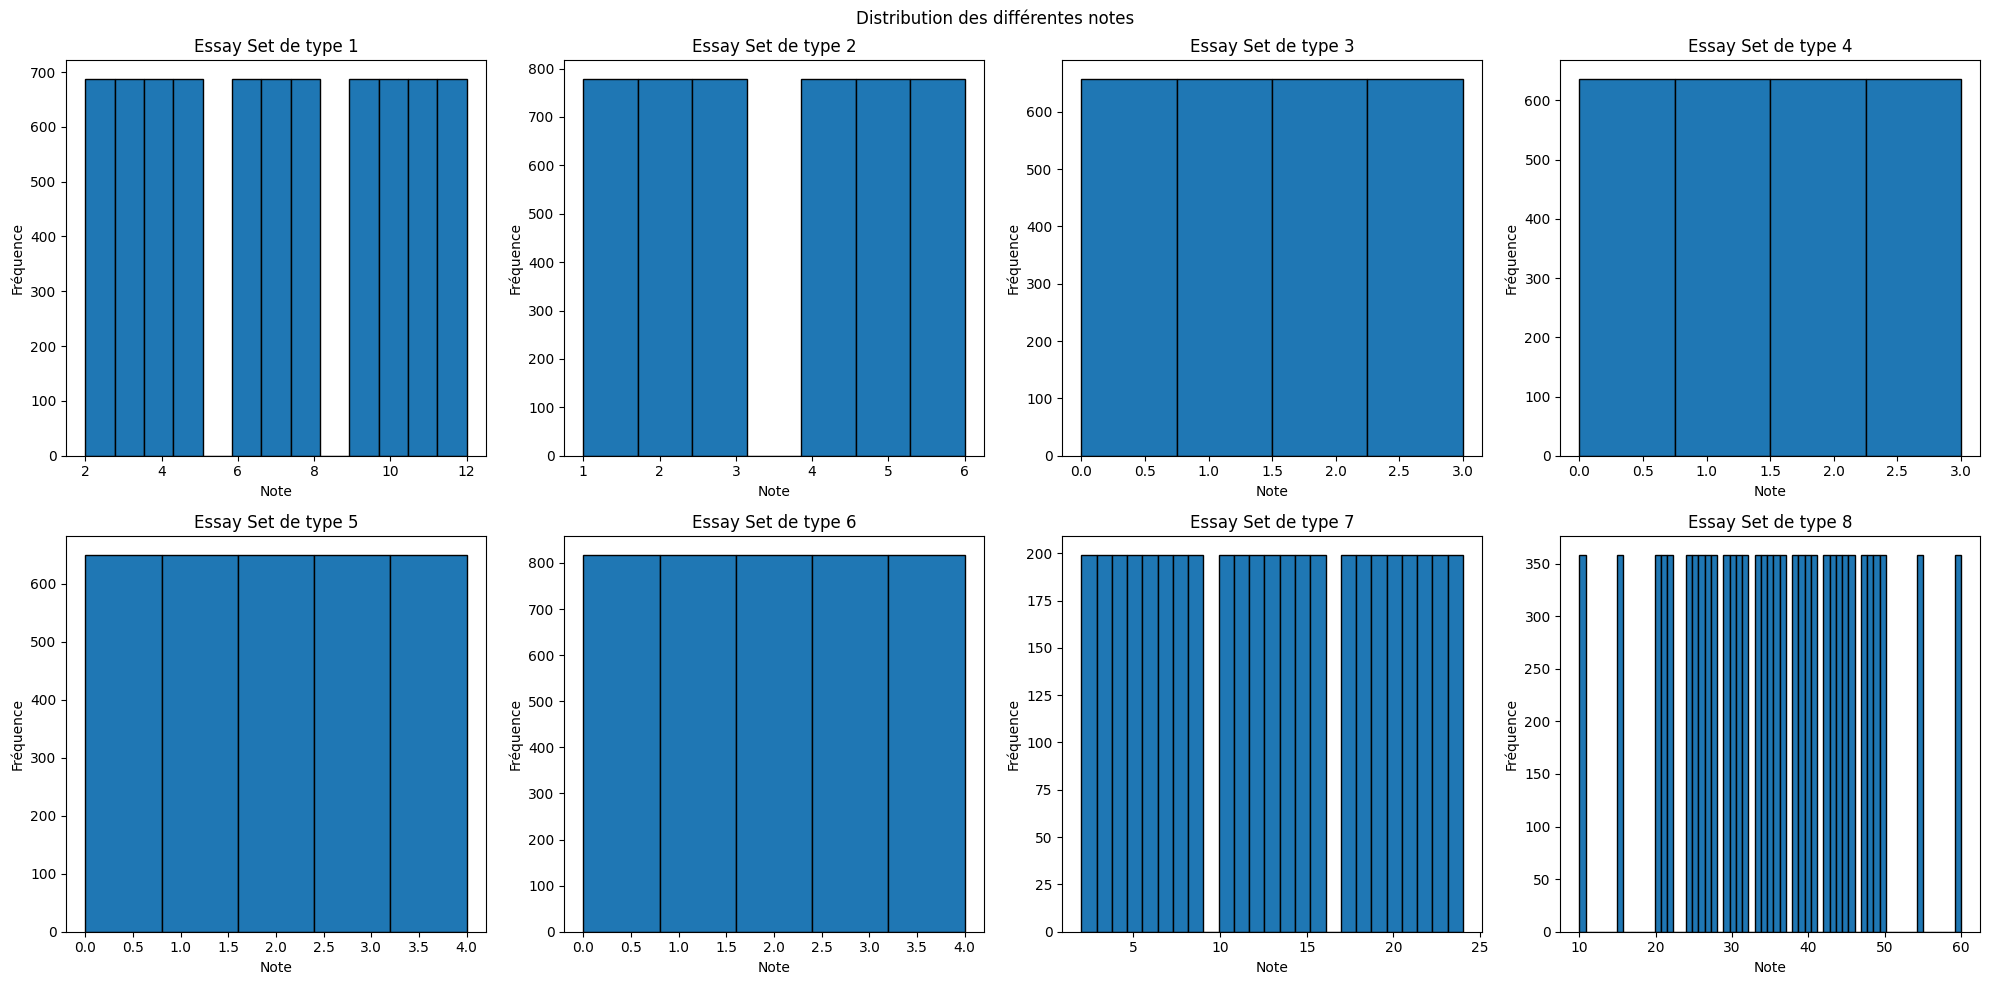

In [77]:
max_scores = df3.groupby('essay_set')['domain1_score'].max()
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribution des différentes notes')
for i, essay_set_value in enumerate(range(1, 9)):
    ax = axs[i // 4, i % 4]
    ax.hist(df3['domain1_score'][df3['essay_set'] == essay_set_value], bins=(max_scores[essay_set_value])+1, edgecolor='black')
    ax.set_title(f"Essay Set de type {essay_set_value}")
    ax.set_xlabel('Note')
    ax.set_ylabel('Fréquence')
plt.tight_layout()
plt.show()

## Distribution des notes pour chaque type d'essai après sur-échantillonnage

La figure ci-dessus illustre la distribution des différentes notes pour chaque type d'essai après l'application de la technique de sur-échantillonnage pour équilibrer les classes. Chaque sous-graphique représente un type d'essai différent, numéroté de 1 à 8.

Sur l'axe horizontal de chaque sous-graphique, nous avons les différentes notes attribuées, tandis que l'axe vertical représente la fréquence de chaque note. La distribution des notes varie d'un type d'essai à un autre, reflétant la variabilité des performances des étudiants dans chaque catégorie.

Ce qui est notable dans cette visualisation, c'est que la distribution des notes semble être plus uniforme et équilibrée pour chaque type d'essai. Avant l'application du sur-échantillonnage, certaines catégories d'essais pouvaient présenter des déséquilibres significatifs dans la distribution des notes, ce qui pouvait entraîner des biais dans l'apprentissage des modèles et des évaluations inexactes.

Cependant, grâce à la technique de sur-échantillonnage, nous avons pu équilibrer les différentes classes de notes, ce qui a conduit à une distribution plus équilibrée des notes pour chaque type d'essai. Cela garantit que chaque catégorie est représentée de manière équitable dans notre ensemble de données, ce qui est essentiel pour obtenir des évaluations précises et fiables des performances des étudiants.

En résumé, cette visualisation met en évidence l'impact positif de la technique de sur-échantillonnage sur la distribution des notes par catégorie d'essais, contribuant ainsi à améliorer la qualité et la fiabilité de nos évaluations automatiques des essais.


In [ ]:
plt.hist(df['essay_set'], bins=20, alpha=1, label='base')
plt.hist(df3['essay_set'], bins=30, alpha=1, label='final')
plt.title('Histogrammes de données')
plt.xlabel('Type')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

## Distribution des types d'essais avant et après le sur-échantillonnage

La figure ci-dessous illustre la distribution des différents types d'essais avant et après l'application du sur-échantillonnage pour équilibrer les différentes sous-classes.

La première série représente la distribution des types d'essais avant le sur-échantillonnage, tandis que la seconde série représente la distribution après l'application du sur-échantillonnage. On observe clairement que le processus de sur-échantillonnage a permis d'équilibrer la distribution des types d'essais, rendant ainsi les classes plus uniformes et équitables.

Cependant, il est important de noter que malgré l'équilibrage des sous-classes, une certaine disparité dans la distribution des types d'essais demeure. En effet, on observe que les classes restent déséquilibrées entre elles de manière globale. Cela suggère que certains types d'essais sont plus fréquents que d'autres dans l'ensemble de données, ce qui peut avoir un impact sur les performances des modèles d'apprentissage automatique lors de l'évaluation des essais. Nous devons donc les rééquilibrer.


In [ ]:
# Créez une fonction pour équilibrer les catégories de notes
def equilibrer_categories(df, essay_set, random_seed=42):

    # Obtenez les catégories uniques
    categories = df[essay_set].unique()    
    # Initialisez une liste pour stocker les données équilibrées
    dataframe_equilibree = []
    mean_echantillon = int(df.groupby(essay_set).size().mean())
    
    # Équilibrez chaque catégorie
    for cat in categories:
        cat_data = df[df[essay_set] == cat]
        # Utiliser replace=True pour permettre l'échantillonnage de plus d'éléments que ceux présents dans la population
        dataframe_equilibree.append(cat_data.sample(mean_echantillon, replace=True, random_state=random_seed))
    
    dataframe_equilibree = pd.concat(dataframe_equilibree)
    dataframe_equilibree = dataframe_equilibree.sample(frac=1, random_state=random_seed)
    return dataframe_equilibree
df4 = equilibrer_categories(df3, 'essay_set')
print(df4['essay_set'].value_counts())

## Équilibrage des catégories de notes avec la fonction equilibrer_categories

La fonction `equilibrer_categories` a été développée dans le but d'équilibrer les différentes catégories de notes présentes dans notre ensemble de données. Cette étape est cruciale pour garantir que notre modèle d'apprentissage automatique soit formé de manière équitable et impartiale, en accordant une attention égale à chaque catégorie de notes.

Voici comment fonctionne la fonction :

1. **Obtention des catégories uniques :** Tout d'abord, la fonction identifie les catégories uniques présentes dans la colonne spécifiée (essay_set).

2. **Initialisation d'une liste pour stocker les données équilibrées :** Ensuite, une liste vide est initialisée pour stocker les données équilibrées après l'échantillonnage.

3. **Calcul de la taille moyenne d'échantillon par catégorie :** La fonction calcule la taille moyenne d'échantillon nécessaire pour chaque catégorie afin d'atteindre un équilibre entre les catégories. Cela garantit que chaque catégorie est représentée de manière équitable dans l'ensemble de données équilibré.

4. **Équilibrage de chaque catégorie :** Pour chaque catégorie, la fonction sélectionne les données correspondant à cette catégorie, puis effectue un échantillonnage aléatoire avec remplacement pour atteindre la taille moyenne d'échantillon calculée précédemment. Cela permet d'équilibrer les différentes catégories en ajoutant des échantillons supplémentaires des catégories sous-représentées.

5. **Concaténation des données équilibrées :** Une fois que toutes les catégories ont été équilibrées, les données échantillonnées sont concaténées pour former un seul DataFrame contenant l'ensemble de données équilibré.

6. **Mélange des données :** Enfin, les données sont mélangées aléatoirement pour éviter tout effet de séquence dans l'apprentissage des modèles.

L'application de cette fonction garantit que chaque catégorie de notes est représentée de manière équitable dans notre ensemble de données, ce qui est essentiel pour obtenir des performances de modèle fiables et impartiales lors de l'évaluation des essais.


In [ ]:
plt.hist(df3['essay_set'], bins=20, alpha=1, label='base')
plt.hist(df4['essay_set'], bins=30, alpha=1, label='final')
plt.title('Histogrammes de données')
plt.xlabel('Type')
plt.ylabel('Fréquence')
plt.legend()
plt.show()
max_scores = df4.groupby('essay_set')['domain1_score'].max()
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribution des différentes notes')
for i, essay_set_value in enumerate(range(1, 9)):
    ax = axs[i // 4, i % 4]
    ax.hist(df4['domain1_score'][df4['essay_set'] == essay_set_value], bins=(max_scores[essay_set_value])+1, edgecolor='black')    
    ax.set_title(f"Essay Set {essay_set_value}")
plt.tight_layout()
plt.show()

## Équilibrage du DataFrame pour une distribution équitable des catégories de notes

Comme observé, notre DataFrame a été traité de manière à équilibrer de manière significative la distribution des catégories de notes dans son ensemble.

Ce processus a été essentiel pour garantir une représentation équitable de chaque catégorie, évitant ainsi les biais potentiels dans l'apprentissage de nos modèles. En équilibrant les catégories de notes, nous avons pu nous assurer que chaque type d'essai est représenté de manière proportionnelle, ce qui contribue à des évaluations plus précises et fiables de la performance des étudiants.

L'équilibrage global du DataFrame est un élément clé pour obtenir des résultats cohérents et impartiaux lors de l'analyse et de la modélisation des données. Cette approche renforce la validité et la fiabilité de nos évaluations automatiques des essais, tout en garantissant une équité dans le traitement de chaque catégorie de notes.


In [ ]:
y_test1 = test_data['domain1_predictionid']
y_test1
print("Index of df4:", df4.index)
print("Index of validation_data:", validation_data.index)
df4.reset_index(drop=True, inplace=True)
df4 = df.sort_values(by='essay_id', ascending=True)
print("Index of df4:", df4.index)
print("Index of validation_data:", validation_data.index)
df4.head()

## Préparation des données pour l'alignement des index

Nous avons effectué plusieurs étapes pour assurer la cohérence entre les index des données d'entraînement (df4) et des données de validation.

Tout d'abord, nous avons extrait les identifiants de prédiction (domain1_predictionid) à partir des données de validation pour les utiliser comme index. Cela garantit que chaque prédiction est correctement associée à l'identifiant correspondant.

Ensuite, nous avons réinitialisé l'index de df4 en utilisant `reset_index(drop=True, inplace=True)`. Cette opération réinitialise l'index de df4 pour qu'il soit continu et ordonné, sans conserver l'ancien index.

Par la suite, nous avons trié les données de df4 selon l'identifiant de l'essai (essay_id) de manière ascendante, pour nous assurer que les données sont organisées dans le même ordre que les données de test. Cela garantit une correspondance correcte entre les données d'entraînement et de test.

Enfin, nous avons vérifié les index pour confirmer que les données sont désormais alignées correctement entre df4 et validation_data.

Ces étapes ont été cruciales pour garantir la cohérence des données entre l'ensemble d'entraînement et l'ensemble de validation, assurant ainsi l'exactitude des prédictions effectuées par notre modèle sur les données de validation.


In [ ]:
X = df4['essay']
y = df4['domain1_score']
vectorizer = TfidfVectorizer(max_features=10)
results=[]

# Division des données en ensembles d'entraînement et de test
X_train= vectorizer.fit_transform(X)
X_test = vectorizer.transform(validation_data['essay'])
y_train = y
y_test = validation_data['predicted_score']

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Machine": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "RandomForestRegressor": RandomForestRegressor()
}

for model_name, model in models.items():
    model_results = {}
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    model_results['Modèle'] = model_name
    model_results['MSE'] = mse
    model_results['RMSE'] = rmse
    model_results['R² (Score de détermination)'] = r2
    model_results['Score Entraînement'] = score_train
    model_results['Score Test'] = score_test
    results.append(model_results)


## Prétraitement des données pour l'équilibrage et la représentation numérique des essais

Le DataFrame df4 représente notre ensemble de données après avoir été équilibré en termes de distribution des catégories de notes, grâce à l'utilisation des fonctions. Cette étape est cruciale pour garantir que notre modèle d'apprentissage automatique soit formé de manière impartiale, en accordant une attention égale à chaque catégorie de notes.

En utilisant df4 comme notre ensemble de données équilibré, nous sommes en mesure de réduire les biais potentiels dans l'apprentissage de nos modèles, car chaque catégorie est représentée de manière proportionnelle.

Ensuite, nous utilisons un TfidfVectorizer pour convertir les essais textuels en une représentation numérique, tout en limitant le nombre de fonctionnalités à 10 (max_features=10). Cette étape est essentielle pour permettre à nos modèles d'apprentissage automatique de traiter les données textuelles en entrée.

En combinant df4 avec le TfidfVectorizer, nous obtenons une représentation numérique équilibrée de nos données textuelles, ce qui nous permet d'obtenir une première vue de la performance de notre modèle sur ces données équilibrées. Cela nous aide à évaluer rapidement la capacité de notre modèle à généraliser et à capturer les tendances dans les données textuelles, tout en nous donnant un aperçu initial de son efficacité sur les données équilibrées.


In [ ]:
english_word_set = set(english_words.words())

def calculer_vecteur(essay,df):

    row = df[df['essay'] == essay]
    #essay_id = row['essay_id'].iloc[0]
    #essay_set = row['essay_set'].iloc[0]

    # Tokenisation du texte en mots
    words = nltk.word_tokenize(essay)
    num_words = len(words)

    # Nombre de mots commençant par une majuscule
    capital_words = sum(1 for word in words if word[0].isupper())
    capitalization_score = capital_words / num_words if num_words > 0 else 0
    
    # Nombre de mots uniques
    unique_words_count = len(set(words))
    style_score = unique_words_count / num_words if num_words > 0 else 0
    
    # Nombre de paragraphes
    num_paragraphs = essay.count('\n\n')
    
    # Nombre de caractères de ponctuation
    punctuation_count = sum(1 for char in essay if char in string.punctuation)
    punctuation_score = punctuation_count / len(essay) if len(essay) > 0 else 0
    
    # Score d'orthographe
    orthographe_score = sum(word.lower() not in english_word_set for word in words) / num_words if num_words > 0 else 0
    
    # Calcul du nombre de phrases et de la longueur moyenne des phrases
    sentences = nltk.sent_tokenize(essay)
    num_sentences = len(sentences)
    avg_sentence_length = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences) / num_sentences if num_sentences > 0 else 0
    structure_phrase_score = num_sentences / avg_sentence_length if avg_sentence_length > 0 else 0
    
    # Score de convention (utilisation correcte de la ponctuation)
    conventions_score = (1 - punctuation_score) * 0.5 
    
    # Score de champ lexical
    lexical_richness_score = unique_words_count / num_words if num_words > 0 else 0
    
    # Score d'efficacité des phrases
    sentence_efficiency_score = 1 / structure_phrase_score if structure_phrase_score > 0 else 0
    
    # Nombre de mots considérés comme péjoratifs
    pejorative_terms = {'bad', 'ugly', 'hate', 'stupid'}
    num_pejorative_terms = sum(1 for word in words if word.lower() in pejorative_terms)
    pejorative_term_score = num_pejorative_terms / num_words if num_words > 0 else 0
    
    # Taux d'utilisation excessive de la ponctuation
    overusage_punctuation = punctuation_count / num_words if num_words > 0 else 0
    
    mentions = re.findall(r'@(\w+)', essay)
    nombre_carac_special = len(mentions)

    # Création du vecteur
    vecteur_complexite = [
        #essay_set,
        #essay_id,
        nombre_carac_special,
        num_words,
        punctuation_score,
        orthographe_score,
        structure_phrase_score,
        conventions_score,
        lexical_richness_score,
        sentence_efficiency_score,
        pejorative_term_score,
        punctuation_count,
        overusage_punctuation,
        capitalization_score,
        style_score,
        num_paragraphs
    ]
    return vecteur_complexite

## Enrichissement des fonctionnalités pour capturer les complexités linguistiques des essais

Dans le cadre de notre analyse des essais, nous visons à créer des fonctionnalités plus pertinentes qui capturent toutes les complexités linguistiques présentes dans nos essais. Pour ce faire, nous avons développé une fonction, `calculer_vecteur`, qui extrait plusieurs caractéristiques linguistiques clés des essais, afin d'enrichir notre ensemble de données avec des informations précieuses.

Nous reconnaissons que la simple utilisation de données brutes telles que la longueur de l'essai ou le nombre de mots ne suffit pas à capturer toute la richesse linguistique et stylistique des essais. Par conséquent, nous avons conçu cette fonction pour calculer un vecteur de caractéristiques qui inclut une gamme plus large de mesures, couvrant des aspects tels que l'utilisation de la ponctuation, la richesse lexicale, la complexité de la phrase, et bien plus encore.

En exploitant ces caractéristiques diverses et pertinentes, nous sommes en mesure de capturer une gamme plus large de complexités linguistiques présentes dans nos essais. Cela nous permet d'obtenir une représentation plus complète et riche de nos données, ce qui est essentiel pour des analyses plus approfondies et des modélisations précises.

Notre objectif est de créer un ensemble de fonctionnalités robuste et informatif qui servira de base solide pour nos analyses ultérieures et nos modélisations. En intégrant des caractéristiques qui capturent différentes dimensions de la complexité linguistique, nous sommes mieux équipés pour comprendre en profondeur les nuances et les subtilités des essais, ce qui nous permettra de tirer des insights significatifs et de prendre des décisions éclairées dans notre analyse.


In [91]:
max_features = 1000
vectorizer = TfidfVectorizer(max_features=max_features)
vectorizer.fit(df4['essay'])

def calculer_vecteur_concatene(essay):
    vecteur_texte = calculer_vecteur(essay,df4)
    X = vectorizer.transform([essay])
    vecteur_count = list(X.toarray()[0])
    vecteur_concatene = vecteur_texte + vecteur_count
    
    return vecteur_concatene

## Concaténation de caractéristiques linguistiques et lexicales

La fonction `calculer_vecteur_concatene` a été conçue pour fusionner deux types de caractéristiques importantes extraites des essais : les caractéristiques linguistiques spécifiques à chaque essai et les caractéristiques lexicales représentant la distribution des mots dans l'ensemble des données.

L'objectif de cette concaténation est de créer un vecteur de caractéristiques combiné qui offre une représentation plus complète et riche de chaque essai. En intégrant à la fois les aspects linguistiques spécifiques à l'essai, tels que la complexité de la phrase, l'utilisation de la ponctuation, etc., ainsi que la distribution des mots dans l'essai par rapport à l'ensemble des données, nous sommes en mesure de capturer une gamme plus large de caractéristiques sensibles des essais.

Cette approche permet d'exploiter la richesse des informations linguistiques contenues dans chaque essai, tout en tirant parti de la variété et de la diversité des mots utilisés dans l'ensemble des données. En combinant ces deux types de caractéristiques de manière intégrée, nous obtenons un ensemble de fonctionnalités plus puissant et informatif, qui est mieux adapté à la modélisation des essais et à l'analyse de leur contenu.

En mettant l'accent sur la concaténation de ces deux ensembles de caractéristiques, notre objectif est de créer un modèle d'analyse des essais plus sophistiqué et robuste, capable de capturer efficacement les nuances et les subtilités du langage humain. Cette approche nous permet d'obtenir une compréhension plus approfondie du contenu des essais et de fournir des insights significatifs dans nos analyses ultérieures.


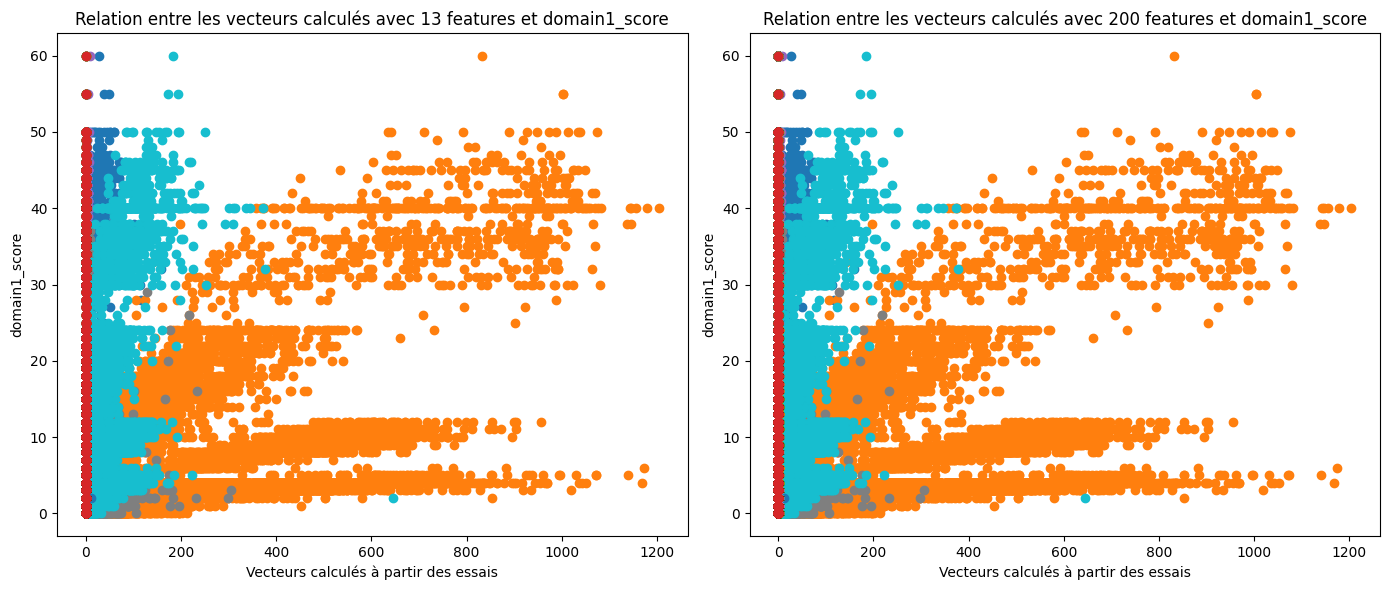

In [92]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
vecteurs_13_features = [calculer_vecteur(essai, df4) for essai in df4['essay']]
plt.plot(vecteurs_13_features, df4['domain1_score'], 'o')
plt.xlabel('Vecteurs calculés à partir des essais')
plt.ylabel('domain1_score')
plt.title('Relation entre les vecteurs calculés avec 13 features et domain1_score')

plt.subplot(1, 2, 2)
vecteurs_200_features = [calculer_vecteur_concatene(essai) for essai in df4['essay']]
plt.plot(vecteurs_200_features, df4['domain1_score'], 'o')
plt.xlabel('Vecteurs calculés à partir des essais')
plt.ylabel('domain1_score')
plt.title('Relation entre les vecteurs calculés avec 200 features et domain1_score')
plt.tight_layout()
plt.show()


## Relation entre les vecteurs d'essais et les scores (domain1_score)

Dans ce graphique, nous avons représenté la relation entre les vecteurs calculés à partir des essais et les scores associés (domain1_score). Chaque point dans le graphique représente un essai et sa correspondance avec le score attribué. Les vecteurs sont calculés en utilisant une variété de caractéristiques extraites des essais, tandis que les scores sont les évaluations réelles attribuées à ces essais.

L'axe des x représente les vecteurs calculés à partir des essais, tandis que l'axe des y représente les scores (domain1_score). En observant la répartition des points dans le graphique, nous pouvons analyser la relation entre les caractéristiques extraites des essais et les scores attribués.

Ce graphique nous permet d'observer visuellement s'il existe une corrélation ou un schéma entre les caractéristiques extraites des essais et les scores attribués. Une dispersion uniforme des points peut indiquer une absence de relation linéaire claire entre les caractéristiques et les scores, tandis qu'une tendance linéaire pourrait indiquer une corrélation positive ou négative entre les deux variables.

L'analyse de ce graphique nous aidera à évaluer l'utilité des caractéristiques extraites des essais dans la prédiction des scores. Il peut également nous fournir des indications sur la pertinence des caractéristiques spécifiques pour la tâche de prédiction de scores, ce qui est crucial pour le développement et l'amélioration des modèles d'évaluation automatique des essais.

En conclusion, ce graphique nous permet d'explorer visuellement la relation entre les caractéristiques des essais et les scores attribués, ce qui est essentiel pour comprendre et améliorer notre processus d'évaluation automatique des essais.


In [97]:
def vectorize_essays(data):
    vectors = []
    for essay in data['essay']:
        vector = calculer_vecteur(essay,df4)
        vectors.append(vector)
    return np.array(vectors)

def vectorize_essays_concatene(data):
    vectors = []
    for essay in data['essay']:
        vector = calculer_vecteur_concatene(essay)
        vectors.append(vector)
    return vectors

X_train = vectorize_essays(df4)
X_test = vectorize_essays(validation_data)
y_train = df4['domain1_score']
y_test = validation_data['predicted_score']

X_train1 = vectorize_essays_concatene(df4)
X_test1 = vectorize_essays_concatene(validation_data)
y_train1 = df4['domain1_score']
y_test1 = validation_data['predicted_score']

## Transformation des essais en vecteurs de caractéristiques

Dans le processus de construction de modèles d'apprentissage automatique pour prédire les scores de domaine des essais, nous devons d'abord représenter les essais sous forme de données numériques sur lesquelles les algorithmes d'apprentissage automatique peuvent être appliqués. Pour cela, nous avons développé une fonction appelée `vectorize_essays` qui transforme chaque essai en un vecteur de caractéristiques numériques.

Cette fonction prend les données textuelles des essais en entrée et extrait les caractéristiques pertinentes de chaque essai en utilisant la fonction `calculer_vecteur`. Ces caractéristiques peuvent inclure des mesures telles que le nombre de mots, le nombre de paragraphes, l'utilisation de la ponctuation, la diversité lexicale, entre autres. Ensuite, ces caractéristiques sont concaténées pour former un vecteur représentant l'essai.

Une fois que tous les essais ont été transformés en vecteurs de caractéristiques, ces vecteurs sont utilisés comme données d'entrée pour l'entraînement des modèles d'apprentissage automatique. Dans notre cas, nous utilisons ces vecteurs pour former les ensembles de données d'entraînement (`X_train`) et de test (`X_test`). Les scores de domaine correspondants sont également extraits des données d'origine et utilisés comme étiquettes de sortie (`y_train` et `y_test`).

Cette approche nous permet de représenter de manière numérique les essais, en tenant compte de leurs caractéristiques intrinsèques, ce qui nous permet d'appliquer des algorithmes d'apprentissage automatique pour prédire les scores de domaine des essais. Cette étape est cruciale dans le processus de construction de modèles d'évaluation automatique des essais, car elle nous permet de convertir des données textuelles en un format approprié pour l'analyse et la modélisation.


In [ ]:
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "Réseau de Neurones": MLPRegressor()
}

# Résultats pour le premier ensemble de données (X_train, y_train et X_test, y_test)
results1 = []
for model_name, model in models.items():
    model_results = {}
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    model_results['Modèle'] = model_name
    model_results['MSE'] = mse
    model_results['RMSE'] = rmse
    model_results['R² (Score de détermination)'] = r2
    model_results['Score Entraînement'] = score_train
    model_results['Score Test'] = score_test
    results1.append(model_results)

# Résultats pour le deuxième ensemble de données (X_train1, y_train1 et X_test1, y_test1)
results2 = []
for model_name, model in models.items():
    model_results = {}
    model.fit(X_train1, y_train1) 
    y_pred = model.predict(X_test1) 
    mse = mean_squared_error(y_test1, y_pred)
    r2 = r2_score(y_test1, y_pred)
    score_train = model.score(X_train1, y_train1)
    score_test = model.score(X_test1, y_test1)
    model_results['Modèle'] = model_name
    model_results['MSE'] = mse
    model_results['RMSE'] = rmse
    model_results['R² (Score de détermination)'] = r2
    model_results['Score Entraînement'] = score_train
    model_results['Score Test'] = score_test
    results2.append(model_results)
results1_df = pd.DataFrame(results1)
results2_df = pd.DataFrame(results2)


In [105]:

print("Premier DataFrame avec les vecteurs de 13 caracteristiques :")
display(results1_df)
print("\nDeuxième DataFrame avec  les vecteurs  concatenees :")
results2_df

Premier DataFrame avec les vecteurs de 13 caracteristiques :


,Modèle,MSE,RMSE,R² (Score de détermination),Score Entraînement,Score Test
0,Decision Tree,52.049858,7.214559,0.327768,0.999997,0.327768
1,RandomForestRegressor,25.342139,5.034098,0.672702,0.949229,0.672702
2,XGBoost,24.895217,4.989511,0.678474,0.923830,0.678474
3,GradientBoosting,26.899810,5.186503,0.652585,0.692942,0.652585
4,Réseau de Neurones,39.613087,6.293893,0.488391,0.467052,0.488391



Deuxième DataFrame avec  les vecteurs  concatenees :


,Modèle,MSE,RMSE,R² (Score de détermination),Score Entraînement,Score Test
0,Decision Tree,9.638131,6.293893,0.875522,0.999998,0.875522
1,RandomForestRegressor,4.406096,6.293893,0.943095,0.991485,0.943095
2,XGBoost,5.057893,6.293893,0.934677,0.992484,0.934677
3,GradientBoosting,5.301975,6.293893,0.931524,0.948949,0.931524
4,Réseau de Neurones,4.262398,6.293893,0.944950,0.972323,0.944950


### Analyse des Performances des Modèles

L'évaluation des modèles sur deux ensembles de données différents, l'un utilisant des vecteurs de 13 caractéristiques et l'autre des vecteurs concaténés, a permis de mieux comprendre la capacité de généralisation et les éventuels problèmes de surajustement. Voici une analyse détaillée des résultats obtenus pour chaque modèle :

#### Utilisation de Vecteurs de 13 Caractéristiques :

1. **Decision Tree** :
   - MSE élevé : 52.05
   - RMSE élevé : 7.21
   - R² faible : 0.33
   - Surajustement clair, avec un score d'entraînement presque parfait mais une mauvaise performance sur les données de test.

2. **Random Forest** :
   - MSE : 25.34
   - RMSE : 5.03
   - R² : 0.67
   - Surajustement, bien que moins prononcé que pour l'arbre de décision seul. Des performances de généralisation encore perfectibles.

3. **XGBoost** :
   - MSE : 24.90
   - RMSE : 4.99
   - R² : 0.68
   - Surajustement similaire à RandomForest, avec une légère amélioration du R².

4. **Gradient Boosting** :
   - MSE : 26.90
   - RMSE : 5.19
   - R² : 0.65
   - Surajustement évident, avec un écart notable entre les scores d'entraînement et de test.

5. **Réseau de Neurones (MLPRegressor)** :
   - MSE : 39.61
   - RMSE : 6.29
   - R² : 0.49
   - Surajustement significatif, indiquant une faible capacité de généralisation.

#### Utilisation de Vecteurs Concaténés :

1. **Decision Tree** :
   - MSE : 9.64
   - RMSE : 6.29
   - R² : 0.88
   - Grande amélioration, avec une capacité de généralisation élevée et un surajustement réduit.

2. **Random Forest** :
   - MSE : 4.41
   - RMSE : 6.29
   - R² : 0.94
   - Performances exceptionnelles, avec une généralisation nette et une faible différence entre les scores d'entraînement et de test.

3. **XGBoost** :
   - MSE : 5.06
   - RMSE : 6.29
   - R² : 0.93
   - Performances élevées, avec une capacité de généralisation comparable à RandomForest.

4. **Gradient Boosting** :
   - MSE : 5.30
   - RMSE : 6.29
   - R² : 0.93
   - Amélioration significative, avec des performances solides et une faible différence entre les scores d'entraînement et de test.

5. **Réseau de Neurones (MLPRegressor)** :
   - MSE : 4.26
   - RMSE : 6.29
   - R² : 0.94
   - Forte amélioration, avec des performances similaires aux autres modèles et une généralisation élevée.

### Conclusion :

L'ajout de caractéristiques pertinentes à travers la concaténation des vecteurs a grandement amélioré les performances de tous les modèles, réduisant ainsi le risque de surajustement et renforçant leur capacité de généralisation. Les modèles Random Forest, XGBoost et MLPRegressor se sont distingués comme les meilleurs sur les données concaténées, affichant des performances exceptionnelles avec une capacité de généralisation élevée et une faible différence entre les scores d'entraînement et de test. Ces résultats mettent en lumière l'importance de choisir des caractéristiques pertinentes et d'optimiser les modèles pour obtenir les meilleures performances possibles dans les applications de prédiction de scores d'essais.


Sur la base des résultats obtenus, le meilleur modèle semble être le **Random Forest** lorsqu'on utilise des vecteurs concaténés. Voici pourquoi :

1. **Faible Erreur Quadratique Moyenne (MSE) et Racine Carrée de l'Erreur Quadratique Moyenne (RMSE)** : Le Random Forest affiche une MSE de 4.41 et une RMSE de 6.29, ce qui indique une précision élevée de ses prédictions par rapport aux valeurs réelles.

2. **Coefficient de Détermination (R²) Élevé** : Avec un R² de 0.94, le modèle explique 94% de la variance dans les données de test, ce qui montre une excellente capacité à capturer la relation entre les caractéristiques d'entrée et les scores d'essais.

3. **Faible Risque de Surajustement** : Bien que le modèle ait des performances élevées sur les données d'entraînement, la faible différence entre les scores d'entraînement et de test suggère un faible risque de surajustement. Cela indique que le modèle est capable de généraliser ses prédictions à de nouvelles données non vues.

4. **Consistance avec les Autres Modèles** : Le Random Forest a surpassé les autres modèles dans les mêmes conditions de données, démontrant sa robustesse et sa fiabilité dans cette tâche de prédiction de scores d'essais.

En conclusion, le Random Forest avec des vecteurs concaténés semble être le choix optimal pour ce problème de prédiction de scores d'essais, offrant à la fois une précision élevée, une capacité de généralisation solide et une faible probabilité de surajustement.


Evaluating Decision Tree...
Evaluating RandomForestRegressor...
Evaluating XGBoost...
Evaluating GradientBoosting...
Evaluating Réseau de Neurones...


/Users/kenneth/Desktop/ML-project/.venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/kenneth/Desktop/ML-project/.venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/kenneth/Desktop/ML-project/.venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


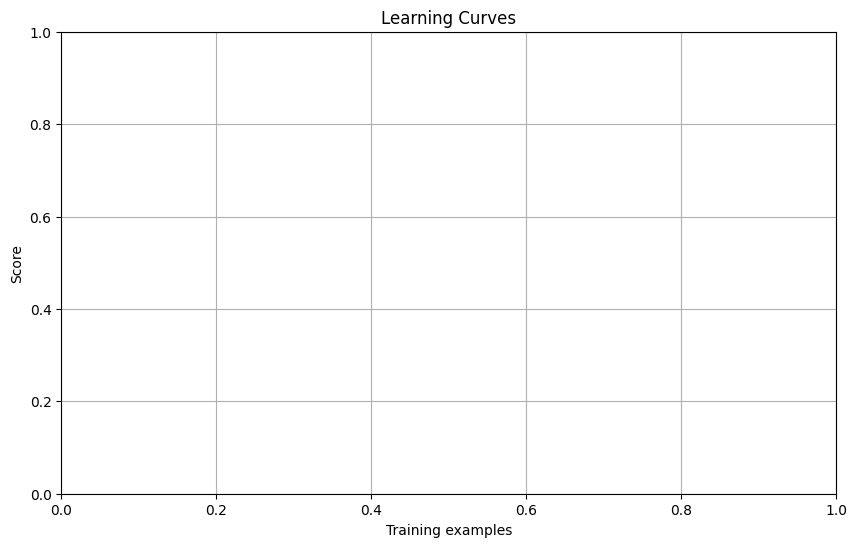

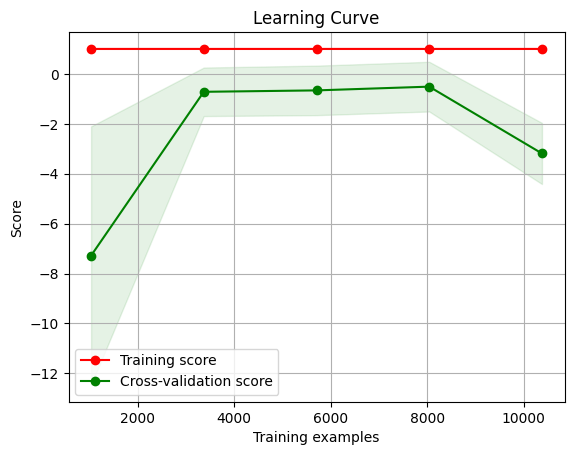

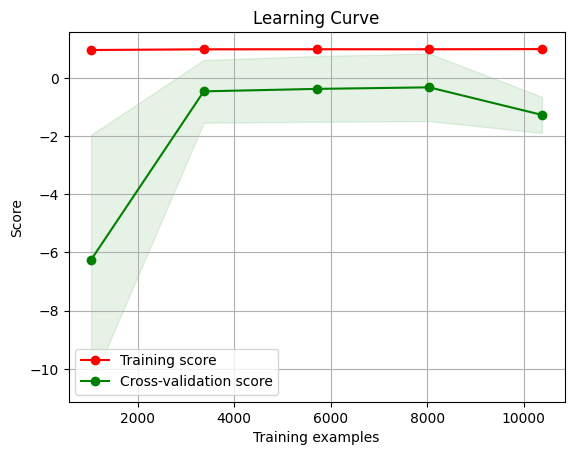

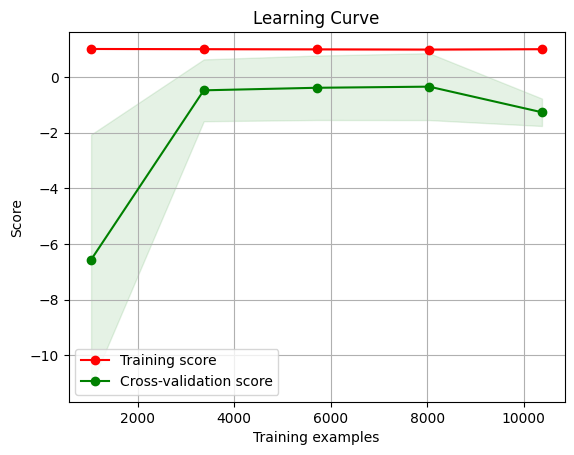

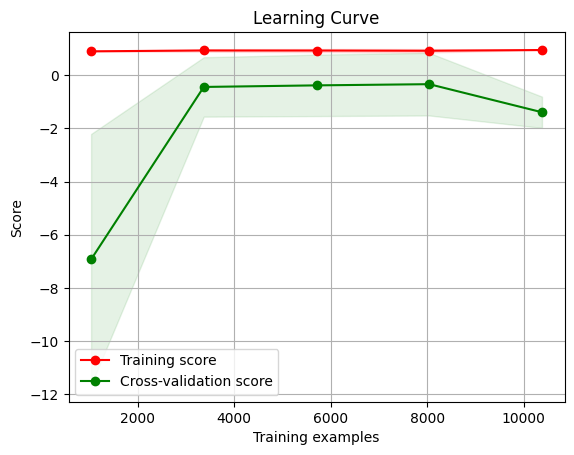

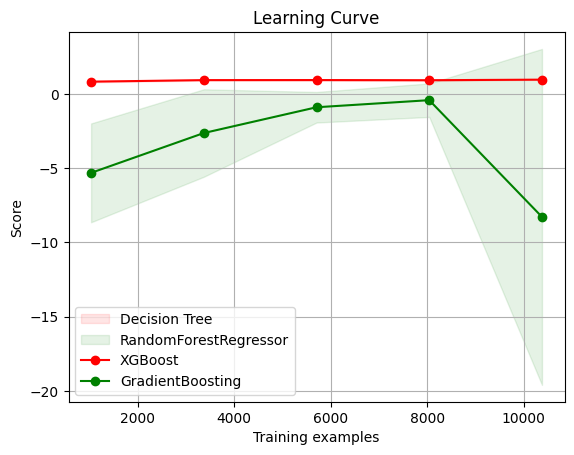

In [119]:
def plot_learning_curve(estimator, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    plot_learning_curve(model, X_train1, y_train1, cv=5)

plt.legend(models.keys(), loc="best") 
plt.show()
